SampleDB(sample_ids=['20220426_RM0008_130hpf_fP1_f3', '20220118_RM0012_124hpf_fP8_f2', '20220427_RM0008_126hpf_fP3_f3'])
20220427_RM0008_126hpf_fP3_f3


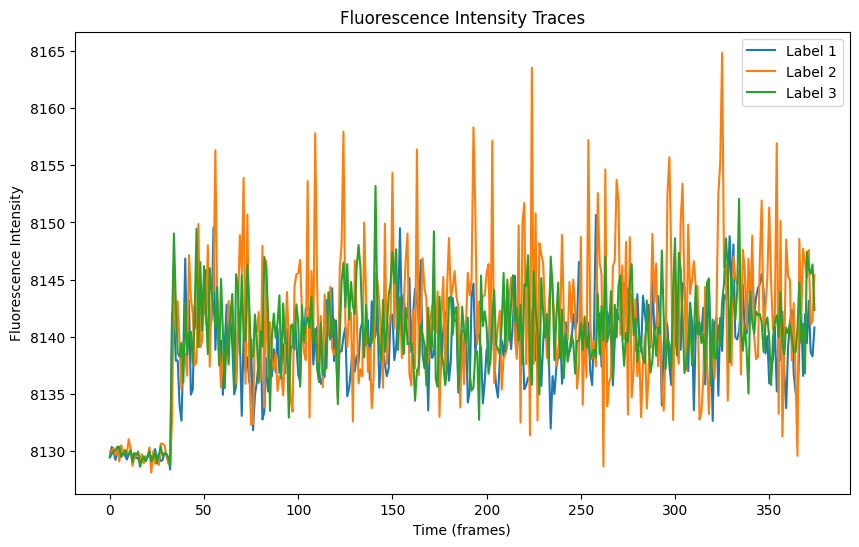

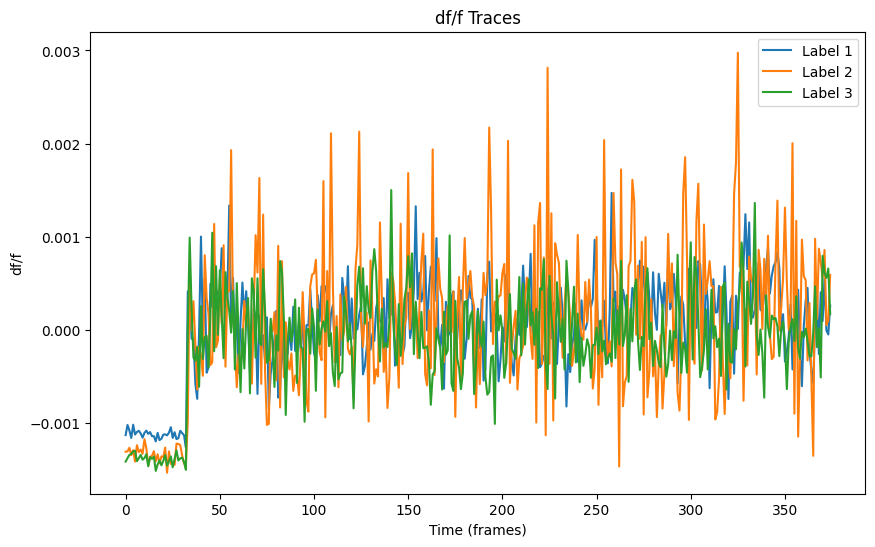

df/f traces calculated and saved in HDF5 file.


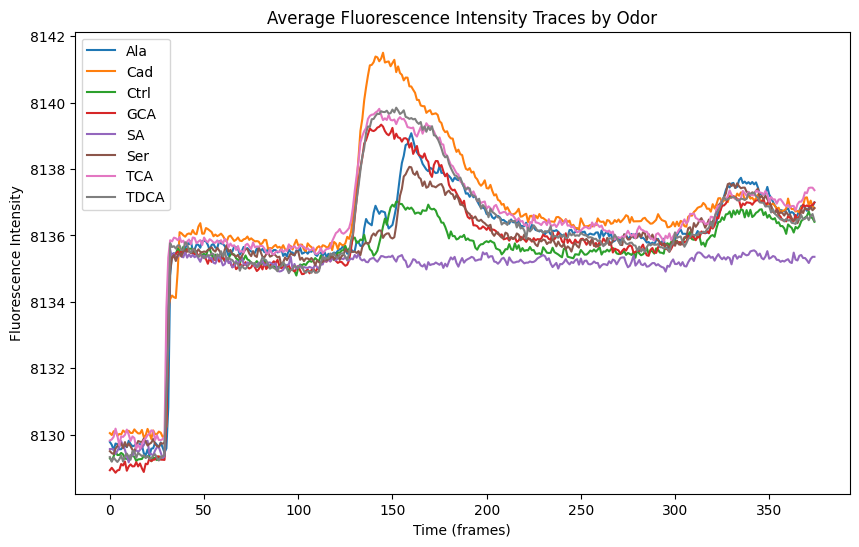

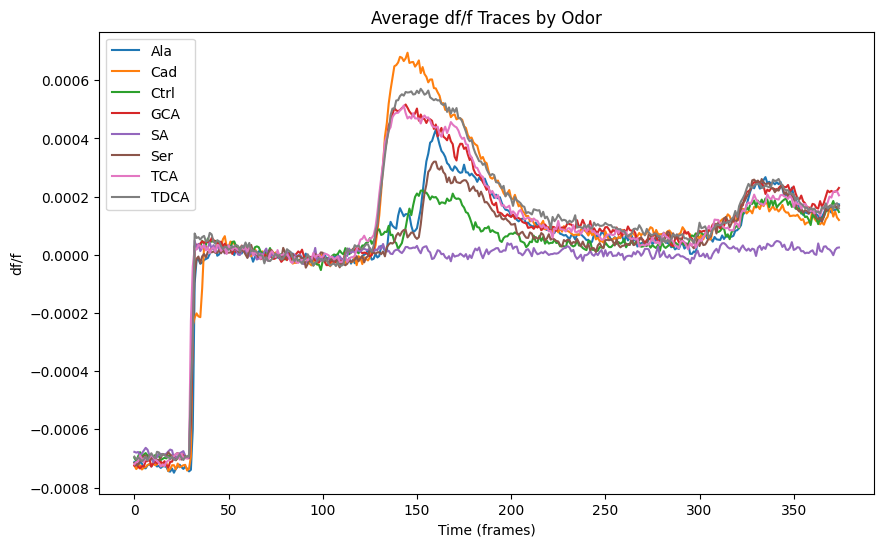

In [12]:
import numpy as np
import os
from tifffile import imread
import h5py
import matplotlib.pyplot as plt
from scripts.sample_db import SampleDB

def load_data(hdf5_file_path, sample_id):
    with h5py.File(hdf5_file_path, 'r') as f:
        exp_grp = f[sample_id]
        return {key: exp_grp[key][()] for key in exp_grp.keys() if isinstance(exp_grp[key], h5py.Dataset)}

def calculate_dff(traces, baseline_frames=[50,100]):
    f0 = np.mean(traces[:, baseline_frames[0]:baseline_frames[1]], axis=1)
    dff = (traces - f0[:, np.newaxis]) / f0[:, np.newaxis]
    return dff

def plot_traces(traces, labels, title, ylabel, n_examples=3):
    plt.figure(figsize=(10, 6))
    for i in range(n_examples):
        plt.plot(traces[i], label=f'Label {labels[i]}')
    plt.title(title)
    plt.xlabel('Time (frames)')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

def plot_average_traces_by_group(traces, groups, title, ylabel):
    unique_groups = np.unique(groups)
    plt.figure(figsize=(10, 6))
    for group in unique_groups:
        plt.plot(traces[groups == group].mean(axis=0), label=group.decode('utf-8'))
    plt.legend()
    plt.title(title)
    plt.xlabel('Time (frames)')
    plt.ylabel(ylabel)
    plt.show()



# Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)
print(sample_db)

# Loading experiment
sample_id = '20220427_RM0008_126hpf_fP3_f3'  
exp = sample_db.get_sample(sample_id)
print(exp.sample.id)

# Making shortcuts of sample parameters/information
sample = exp.sample
trials_path = exp.paths.trials_path
n_planes = exp.params_lm.n_planes
n_trials = exp.params_lm.n_trials
doubling = 2 if exp.params_lm.doubling else 1

# Getting paths of the trial acquisitions
trial_names = os.listdir(os.path.join(trials_path, 'raw'))
processed_folder = os.path.join(trials_path, 'processed')
masks_folder = os.path.join(trials_path, "masks")


# Create folder for saving fluorescence data
traces_folder = os.path.join(trials_path, "traces")
os.makedirs(traces_folder, exist_ok=True)

hdf5_file_path = os.path.join(traces_folder, f'{exp.sample.id}_fluorescence_data.h5')

data = load_data(hdf5_file_path, exp.sample.id)

# Calculate df/f traces
dff_traces = calculate_dff(data['raw_traces'], baseline_frames=[50,100])

# Plot example raw traces
plot_traces(data['raw_traces'], data['lm_plane_labels'], 'Fluorescence Intensity Traces', 'Fluorescence Intensity')

# Plot example df/f traces
plot_traces(dff_traces, data['lm_plane_labels'], 'df/f Traces', 'df/f')

# Save df/f traces to HDF5 file
with h5py.File(hdf5_file_path, 'r+') as f:
    exp_grp = f[sample_id]
    if 'dff_traces' in exp_grp:
        del exp_grp['dff_traces']
    exp_grp.create_dataset('dff_traces', data=dff_traces)

print("df/f traces calculated and saved in HDF5 file.")

# Plot average raw traces for each odor
plot_average_traces_by_group(data['raw_traces'], data['odor'], 'Average Fluorescence Intensity Traces by Odor', 'Fluorescence Intensity')

# Plot average df/f traces for each odor
plot_average_traces_by_group(dff_traces, data['odor'], 'Average df/f Traces by Odor', 'df/f')
